In [246]:
import numpy as np
import pandas as pd
import os
from keras import backend as K
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D
from keras.models import Model, Sequential, load_model
from keras.regularizers import l2
from keras import backend as K
import random
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
%matplotlib inline

In [241]:
N_FRAMES = 128
INPUT_DIM = (128, 128, 1)
TRAINED_MODEL_PATH = '/Users/harryxue/Documents/Siamese_FirstTrack_128x128.model'
FEATURE_DIR = '../data/features/mel_spec_first/'

In [3]:
# Load trained model
model = load_model(TRAINED_MODEL_PATH)

/Users/harryxue/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:1269: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [58]:
influences = pd.read_csv('../data/allmusic/influences_cleaned.csv')
artists = pd.read_csv('../data/allmusic/artists_cleaned.csv')

# Create lookup dictionary mapping file id to artist id
file2id = {}

for filename in os.listdir(FEATURE_DIR):
    file2id[filename] = int(filename.split('.npy')[0]) 

id2file = {id:filename for (filename, id) in file2id.items()}

In [5]:
# Load validation relationship pairs
pos_val_rel, neg_val_rel = np.load('relationships/pos_val_rel.npy'), np.load('relationships/neg_val_rel.npy')

In [6]:
def sample_frames(melspec, n_frames):
    """Sample n_frames (contiguous) from a melspec representation"""
    total_frames = melspec.shape[1]
    sample_range = range(0, total_frames - n_frames + 1)
    sample_index = random.choice(sample_range)
    
    return melspec[:, sample_index:sample_index + n_frames]

In [164]:
def predict_val(pos_ex, neg_ex, model=model, n_frames=N_FRAMES):
    # Create binary labels for examples
    labels = np.concatenate((np.ones(len(pos_ex)), np.zeros(len(neg_ex))))
    all_ex = list(zip(np.concatenate((pos_ex, neg_ex)), labels))
    examples, labels = zip(*all_ex)
    
    Y_pred, Y_actual = [], []
    
    random.shuffle(all_ex)
    examples, labels = zip(*all_ex)

    for example, label in tqdm_notebook(zip(examples, labels)):
        # Extract sample of size N_FRAMES from mel_spec representation
        # for each example in pair
        pair_first, pair_second = [sample_frames(np.load(FEATURE_DIR + id2file[id]), n_frames) for id in example]
        pred = model.predict([pair_first[np.newaxis, :, :,np.newaxis], pair_second[np.newaxis, :, :, np.newaxis]])
        Y_pred.append(pred[0][0])
        Y_actual.append(label)
        
    return Y_pred, Y_actual, examples

In [165]:
Y_pred, Y_actual, id_pairs = predict_val(pos_val_rel, neg_val_rel)

A Jupyter Widget

KeyboardInterrupt: 

# Precision, Recall, F-Score

In [41]:
precision_score(Y_actual, np.array(Y_pred) > 0.5)

0.6735259361884194

In [42]:
recall_score(Y_actual, np.array(Y_pred) > 0.5)

0.7440803097145944

In [43]:
f1_score(Y_actual, np.array(Y_pred) > 0.5)

0.707047374612341

# Accuracy for Same Genre Pairs v. Different Genre Pairs

In [53]:
# Create df for tracking whether genres are the same or not
genre_same_df = pd.DataFrame({'Y_actual': Y_actual, 'Y_pred': (pd.Series(Y_pred) > 0.5).apply(float), 'id_pair': id_pairs})

In [68]:
# Add column for whether genre is the same
genre_same_df['same_genre'] = genre_same_df['id_pair'].map(lambda x: artists[artists['id'] == x[0]]['main_genre'].iloc[0] == artists[artists['id'] == x[1]]['main_genre'].iloc[0])

In [71]:
# Add shared genre label if genre is the same
genre_same_df['shared_genre'] = genre_same_df['id_pair'].map(lambda x: artists[artists['id'] == x[0]]['main_genre'].iloc[0] if artists[artists['id'] == x[0]]['main_genre'].iloc[0] == artists[artists['id'] == x[1]]['main_genre'].iloc[0] else None)

In [84]:
# Calculate accuracy, precision, recall, F1 score
# for same genre pairs v. different pairs
print genre_same_df.groupby('same_genre').apply(lambda x: accuracy_score(x['Y_actual'], x['Y_pred']))
print genre_same_df.groupby('same_genre').apply(lambda x: precision_score(x['Y_actual'], x['Y_pred']))
print genre_same_df.groupby('same_genre').apply(lambda x: recall_score(x['Y_actual'], x['Y_pred']))

same_genre
False    0.676125
True     0.708392
dtype: float64
same_genre
False    0.400598
True     0.841977
dtype: float64
same_genre
False    0.672401
True     0.768126
dtype: float64


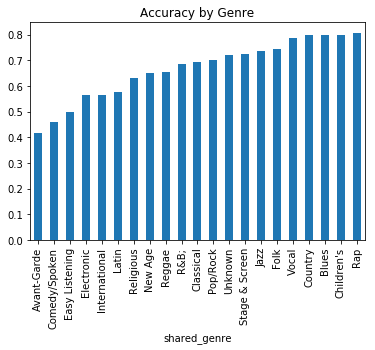

In [120]:
# Accuracy, precision, recall by genre for subset where genre is the same
genre_same_df[genre_same_df['same_genre'] == True].groupby('shared_genre')\
                                                .apply(lambda x: accuracy_score(x['Y_actual'], x['Y_pred']))\
                                                .sort_values()\
                                                .plot('bar', title='Accuracy by Genre')

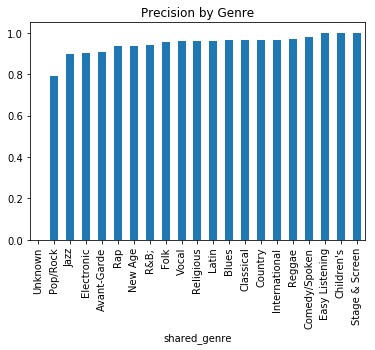

In [121]:
# Accuracy, precision, recall by genre for subset where genre is the same
genre_same_df[genre_same_df['same_genre'] == True].groupby('shared_genre')\
                                                .apply(lambda x: precision_score(x['Y_actual'], x['Y_pred']))\
                                                .sort_values()\
                                                .plot('bar', title='Precision by Genre')

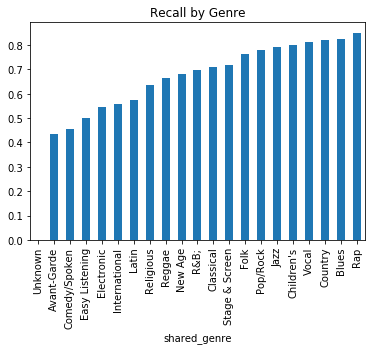

In [122]:
# Accuracy, precision, recall by genre for subset where genre is the same
genre_same_df[genre_same_df['same_genre'] == True].groupby('shared_genre')\
                                                .apply(lambda x: recall_score(x['Y_actual'], x['Y_pred']))\
                                                .sort_values()\
                                                .plot('bar', title='Recall by Genre')

# Embed First Tracks for Each Artist and Visualize

In [284]:
# Use weights from trained model to build a truncated embedding model to get
# fixed size embedding for each sample
input_shape = INPUT_DIM
left_input = Input(input_shape)
right_input = Input(input_shape)

embedding_model = Sequential()
embedding_model.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape, kernel_regularizer=l2(2e-4), weights=[model.layers[2].get_weights()[0], model.layers[2].get_weights()[1]]))
embedding_model.add(MaxPooling2D()) 
embedding_model.add(Conv2D(128,(7,7),activation='relu', kernel_regularizer=l2(2e-4), weights=[model.layers[2].get_weights()[2], model.layers[2].get_weights()[3]]))
embedding_model.add(MaxPooling2D())
embedding_model.add(Conv2D(128,(4,4),activation='relu',kernel_regularizer=l2(2e-4), weights=[model.layers[2].get_weights()[4], model.layers[2].get_weights()[5]]))
embedding_model.add(MaxPooling2D())
embedding_model.add(Conv2D(256,(4,4),activation='relu',kernel_regularizer=l2(2e-4), weights=[model.layers[2].get_weights()[6], model.layers[2].get_weights()[7]]))
embedding_model.add(Flatten())
embedding_model.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3), weights=[model.layers[2].get_weights()[8], model.layers[2].get_weights()[9]]))

In [295]:
def siamese_embed(ids, embedding_model=embedding_model, n_frames=N_FRAMES):
    """Generate fixed size embeddings for samples using the trained Siamese network"""
    preds = []
    
    for id in tqdm_notebook(ids):
        # Extract sample of size N_FRAMES from mel_spec representation
        # for each example in pair
        sample = sample_frames(np.load(FEATURE_DIR + id2file[id]), n_frames) 
        pred = embedding_model.predict([sample[np.newaxis, :, :,np.newaxis]])[0]
        preds.append(pred)
    
    return preds

In [ ]:
ids = id2file.keys()
siamese_embeddings = siamese_embed(ids)

A Jupyter Widget